In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.lines as mlines

import sys
sys.path.insert(0, '../src')

from utils.logger import logger
import utils.visualization as vis
import utils.preprocession as prep
import utils.metrics as met
from IPython.display import display

save_figures = []
save_figures.append('../figures')


In [2]:
number_queries_list = list(range(5,50,5))
results = prep.load_results('../results/aqvaa')

In [3]:
def plot_selection(identifiers, **kwargs):
    params = {'metric': 'RMSE',
              'window': 10,
              'ncols': 2,
              'xmax':None,
              'title':False,
              'ax': None,
              'figwidth': vis.textwidth,
              'figratio': 0.5,
              'smooth': True,
              'legend':True,
              'lw':1}
    params.update(kwargs)
    
    if params['ax'] is None:
        fig, ax = plt.subplots(figsize=(params['figwidth'], params['figratio']*params['figwidth']))
    else:
        fig, ax = params['ax'].figure, params['ax']
        
    common_title_parts = []

    # Create a mapping of column names to list indices
    identifying = ['InitialData', 'Method', 'NumberQueries', 'Model', 'UpdateRate']
    col_to_index = {col: i for i, col in enumerate(identifying)}

    # Determine common and different parts for title and legend
    array_ids = pd.DataFrame(identifiers, columns=identifying+['Baseline']).drop('Baseline', axis=1)
    common_title_parts = array_ids.columns[array_ids.nunique() == 1].tolist()
    different_legend_parts = array_ids.columns[array_ids.nunique() > 1].tolist()

    title=''
    if params['title']:
    # Title for common elements
        title = params['metric']+': '+'_'.join(array_ids[col].iloc[0] for col in common_title_parts)

    stats = {}
    for identifier in identifiers:
        # Create a mask to filter rows based on the identifier
        mask = (results.loc[:, identifying] == identifier[:-1]).all(axis=1)
        df = results.loc[mask, 'DataFrame']
        if df.empty:
            logger.info(f'No results found for {identifier}.')
        else:
            logger.info(f'{identifier[:-1]} has {mask.sum()} hits.')
            data = results.loc[mask, 'DataFrame'].apply(lambda df: df.groupby('ModelVersion')[params['metric']].mean())
            if params['smooth']:
                data = data.T.rolling(window=params['window'], min_periods=1, center=True).mean().T
                moving_avg = data.mean()
            else:
                moving_avg = data.mean().rolling(window=params['window'], min_periods=1, center=True).mean()
            means = data.mean()
            stds = data.std()
            s = np.sqrt(mask.sum())
            singles = stds.isna()

            # Generate the legend label using different_legend_parts and mapping
            legend_label = ' '.join(identifier[col_to_index[col]] for col in different_legend_parts)
            if identifier[-1]:
                # Add average as dashed line
                ax.axhline(means.mean(), lw=0.5, ls='dashed', zorder=5, color='black' ,label=legend_label)
            else:
                # Add MEAN where there is no STD (noisy line)
                # line, = ax.plot(means.index, means.values, lw=.5, ls='dashed')
                # Add MEAN where there is STD (slightly noisy line)
                # line, = ax.plot(means.loc[~singles].index, means.loc[~singles].values, c=line.get_color(), lw=1)
                # Add AVERAGE where there is no STD (rolling mean)
                ax.plot(moving_avg.index, moving_avg.values, lw=params['lw'], label=legend_label)
                # Add Confidence where there is STD (suasage)
                # ax.fill_between(means.index, means-stds/s, means+stds/s, color=line.get_color(), alpha=0.4)
            stats[legend_label] = means, stds/s
    ax.set(title=title,
           xlabel='Number of Users',
           ylabel=params['metric'])
    if params['xmax'] is None:
        ax.set_xlim(left=0)
    else:
        ax.set(xlim=(0,params['xmax']))
    if params['legend']:
        loc = 'lower right' if params['metric'] == 'CRA' else 'best'
        leg = ax.legend(ncol=params['ncols'], loc=loc, facecolor='w')
        leg.get_frame().set_alpha(1)  
    fig.tight_layout()
    return fig, stats


def first_all_positive_index(series):
    # Drop NaN values for the check, but retain original indices
    filtered_series = series.dropna()
    for i in filtered_series.index:
        # Check if all elements from the current index to the end are positive
        if all(x >= 0 for x in filtered_series.loc[i:]):
            return i
    return None  # Return None if no such index exists


def first_positive_index(series):
    # Drop NaN values for the check, but retain original indices
    filtered_series = series.dropna()
    for i in filtered_series.index:
        # Check if all elements from the current index to the end are positive
        if filtered_series.loc[i] >=0:
            return i
    return None  # Return None if no such index exists

### Comparing Datasets

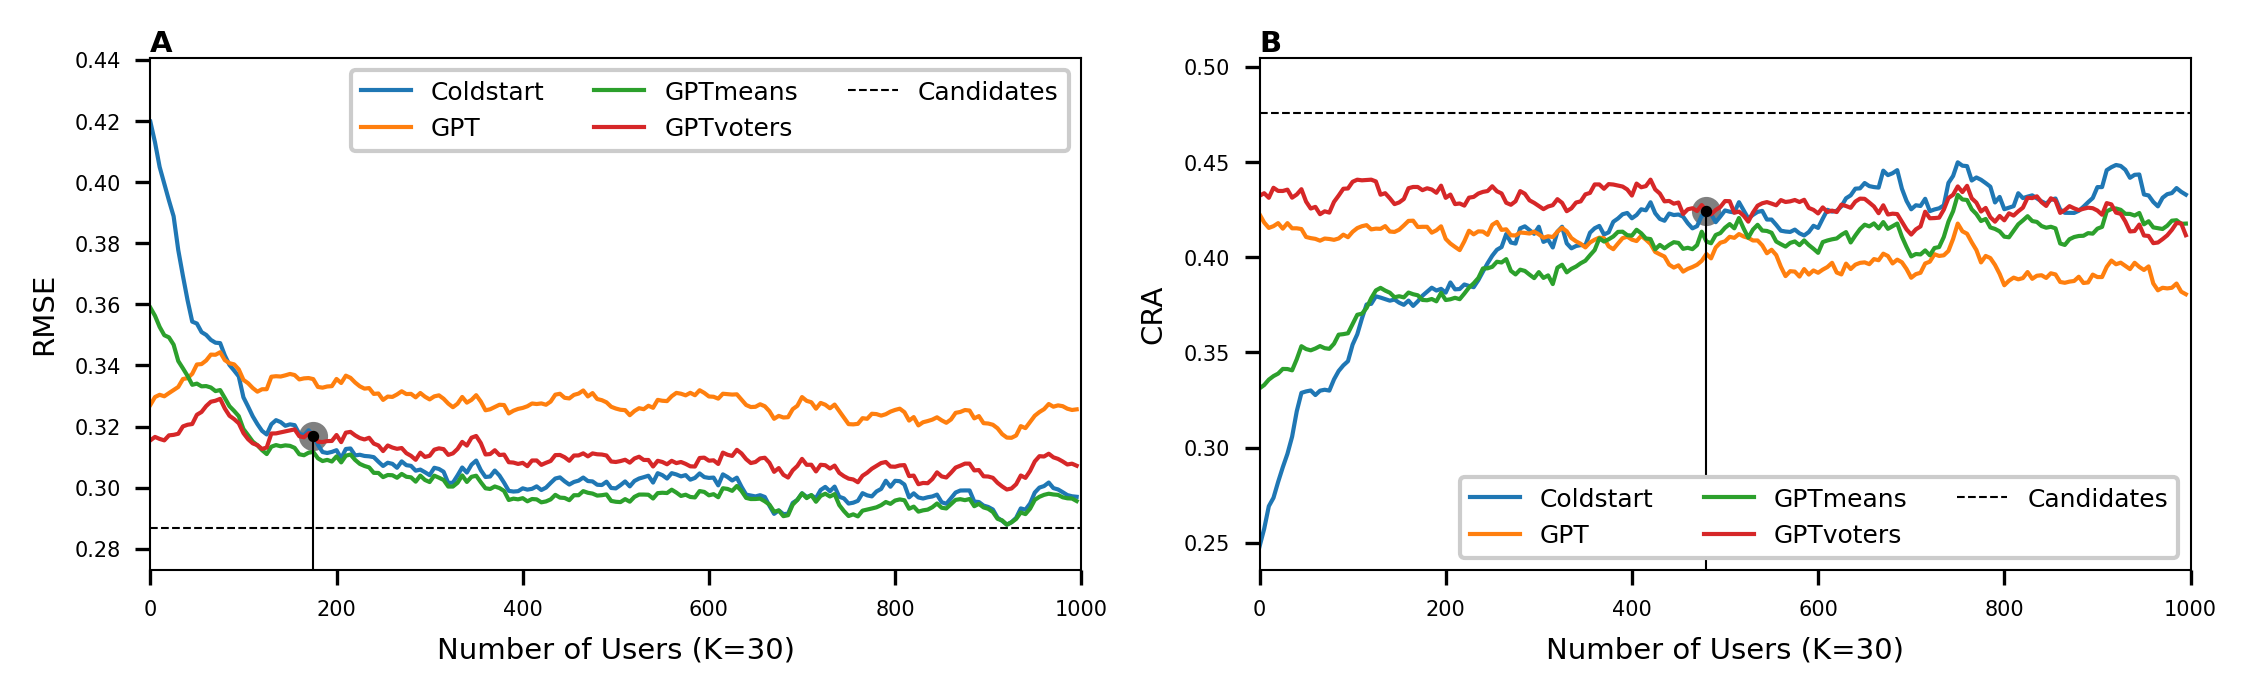

In [4]:
def plot_simulation_results(number_queries = 30, panel=True):
        identifiers = [
        # ['Voters', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
        ['Coldstart', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
        ['GPT', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
        ['GPTmeans', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
        ['GPTvoters', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
        ['Candidates', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', True],
        # ['GPTreplace', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
        ]

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(vis.textwidth, 0.3*vis.textwidth))

        fig, stats2 = plot_selection(identifiers, metric='CRA', window=10, xmax=1000, ax=ax2, ncols=3)

        GPTvoters_stats = pd.DataFrame.from_dict(stats2, orient='index').loc['GPTvoters']
        Coldstart_stats = pd.DataFrame.from_dict(stats2, orient='index').loc['Coldstart']
        difference = - GPTvoters_stats.iloc[0] - GPTvoters_stats.iloc[1] + Coldstart_stats.iloc[0] + Coldstart_stats.iloc[1] 
        idx = first_positive_index(difference)
        val = GPTvoters_stats.iloc[0].loc[idx]
        stats2lim = pd.DataFrame(stats2).iloc[0]
        ymin, ymax = 0.95*stats2lim.apply(min).min(),1.02*stats2lim.apply(max).max()
        ax2.plot([idx, idx], [ymin,val], c='black', lw=0.5)
        ax2.scatter(idx, val, zorder=0, c='grey')
        ax2.scatter(idx, val, zorder=3, s=3, c='black')
        # ax2.text(idx, 0.365, idx, rotation='horizontal', va='top', ha='center', fontsize=5) 
        ax2.set(ylim=(ymin, ymax),
                xlabel=f'Number of Users (K={number_queries})')


        fig, stats1 = plot_selection(identifiers, metric='RMSE', xmax=1000, window=10, ax=ax1, ncols=3)

        GPTvoters_stats = pd.DataFrame.from_dict(stats1, orient='index').loc['GPTvoters']
        Coldstart_stats = pd.DataFrame.from_dict(stats1, orient='index').loc['Coldstart']
        difference = GPTvoters_stats.iloc[0] + GPTvoters_stats.iloc[1] - Coldstart_stats.iloc[0] + Coldstart_stats.iloc[1] 
        difference = GPTvoters_stats.iloc[0] - Coldstart_stats.iloc[0] 
        idx = first_positive_index(difference)
        val = Coldstart_stats.iloc[0].loc[idx]
        stats1lim = pd.DataFrame(stats1).iloc[0]
        ymin, ymax = 0.98*stats1lim.apply(min).min(),1.05*stats1lim.apply(max).max()
        ax1.plot([idx, idx], [ymin,val], c='black', lw=0.5)
        ax1.scatter(idx, val, zorder=0, c='grey')
        ax1.scatter(idx, val, zorder=3, s=3, c='black')
        # fig.axes[0].axvline(idx, c='black', lw=0.5)
        ax1.set(ylim=(ymin, ymax),
                xlabel=f'Number of Users (K={number_queries})')
        
        if panel:
                fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
                fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)

        fig.tight_layout()
        vis.savefig(fig, title=f'Simulation_Results_{number_queries}', destinations=save_figures)

plot_simulation_results(30)

In [5]:
for number_queries in number_queries_list:
    plot_simulation_results(number_queries, panel=False)
    plt.close('all')

### Break even points

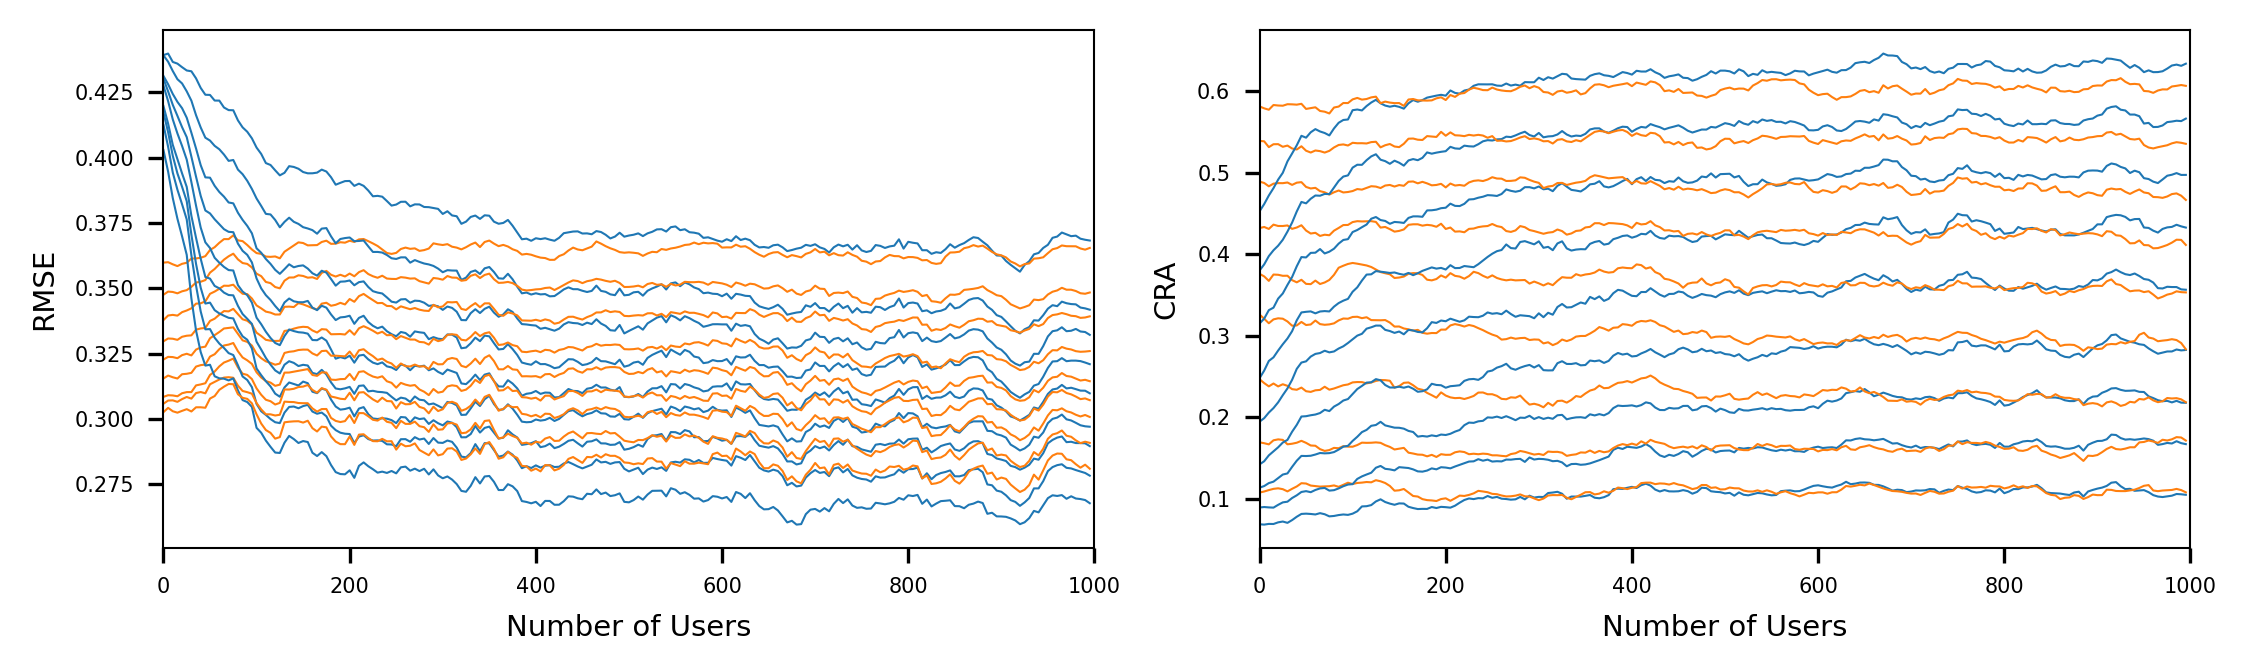

In [6]:
figBEP, (ax1, ax2) = plt.subplots(1,2, figsize=(vis.textwidth, 0.3*vis.textwidth))


identifiers = []
for number_queries in number_queries_list:
    identifiers += [
['Coldstart', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
['GPTvoters', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
]

fig, statsRMSE = plot_selection(identifiers, metric='RMSE', legend=False, lw=0.5, figratio=0.6, xmax=1000, ax=ax1, window=10, figwidth=0.5*vis.textwidth)

lines = fig.axes[0].get_lines()

# Change the color of all lines, alternating between blue and orange
for i, line in enumerate(lines):
    line.set_color(['C0','C1'][i % 2])  # Use modulo to alternate colors

fig, statsCRA = plot_selection(identifiers, metric='CRA', legend=False, lw=.5, figratio=0.6, xmax=1000, ax=ax2,  window=10, figwidth=.5*vis.textwidth)
lines = fig.axes[1].get_lines()

# Change the color of all lines, alternating between blue and orange
for i, line in enumerate(lines):
    line.set_color(['C0','C1'][i % 2])  # Use modulo to alternate colors



In [7]:
RMSE = []
RMSEval = []
for number_queries in number_queries_list:
    A = f'GPTvoters {number_queries}Q'
    B = f'Coldstart {number_queries}Q'
    data =pd.DataFrame.from_dict(statsRMSE, orient='index')
    if A in data.index and B in data.index:
        GPTvoters_stats = data.loc[A]
        Coldstart_stats = data.loc[B]
        difference = GPTvoters_stats.iloc[0] + GPTvoters_stats.iloc[1] - Coldstart_stats.iloc[0] + Coldstart_stats.iloc[1] 
        difference = GPTvoters_stats.iloc[0] - Coldstart_stats.iloc[0] 
        idx = first_positive_index(difference)
        RMSE.append(idx)
        RMSEval.append(GPTvoters_stats.iloc[0].loc[idx])
    else:
        RMSE.append(np.nan)
        RMSEval.append(np.nan)

CRA = []
CRAval = []
for number_queries in number_queries_list:
    A = f'GPTvoters {number_queries}Q'
    B = f'Coldstart {number_queries}Q'
    data =pd.DataFrame.from_dict(statsCRA, orient='index')
    if A in data.index and B in data.index:
        GPTvoters_stats = data.loc[A]
        Coldstart_stats = data.loc[B]
        difference = GPTvoters_stats.iloc[0] + GPTvoters_stats.iloc[1] - Coldstart_stats.iloc[0] + Coldstart_stats.iloc[1] 
        difference = GPTvoters_stats.iloc[0] - Coldstart_stats.iloc[0] 
        idx = first_positive_index(-difference)
        CRA.append(idx)
        CRAval.append(GPTvoters_stats.iloc[0].loc[idx])
    else:
        CRA.append(np.nan)
        CRAval.append(np.nan)

thresholds = pd.DataFrame([RMSE, RMSEval, CRA, CRAval], columns=number_queries_list, index=['RMSE', 'RMSEval', 'CRA', 'CRAval']).T
thresholds

,RMSE,RMSEval,CRA,CRAval
5,895.0,0.363020,290.0,0.102834
10,380.0,0.350960,485.0,0.159286
15,290.0,0.343700,650.0,0.231834
20,310.0,0.332426,630.0,0.294726
25,185.0,0.324212,630.0,0.365894
30,175.0,0.317766,485.0,0.422486
35,160.0,0.311112,395.0,0.491058
40,100.0,0.306080,255.0,0.539322
45,85.0,0.308090,175.0,0.588820


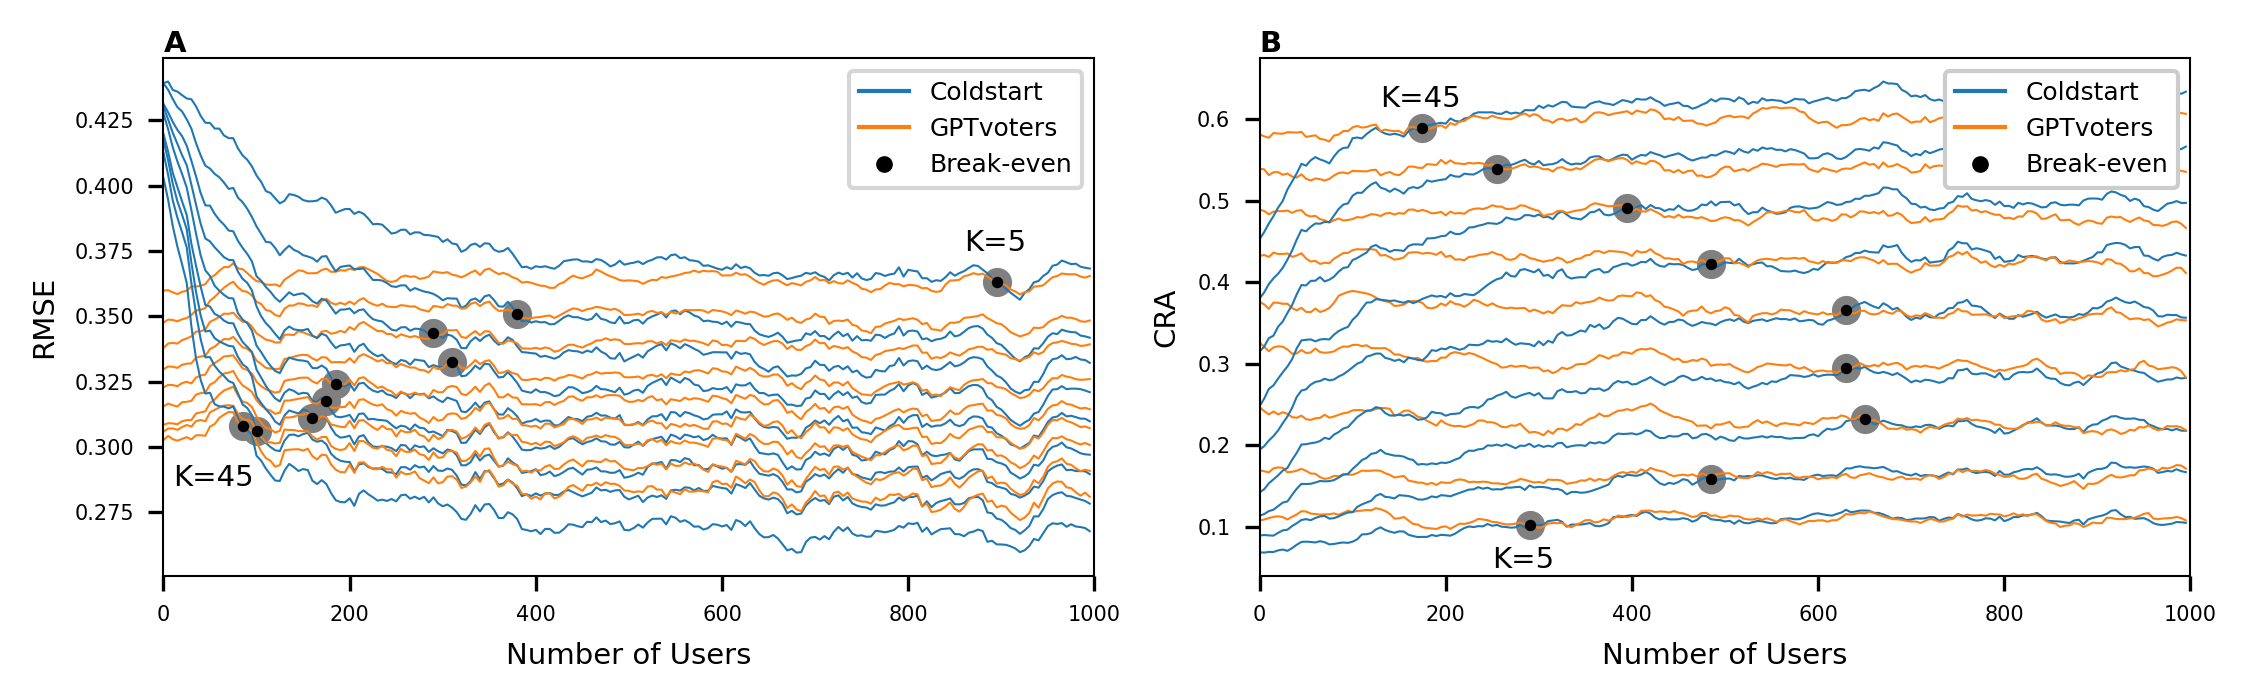

In [8]:
ax = figBEP.axes[0]
lines = ax.get_lines()
ax.scatter(thresholds['RMSE'], thresholds['RMSEval'], zorder=0, c='grey')
ax.scatter(thresholds['RMSE'], thresholds['RMSEval'], zorder=3, s=3, c='black')
blue_line = mlines.Line2D([], [], color='C0', label='Coldstart')
orange_line = mlines.Line2D([], [], color='C1', label='GPTvoters')
black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=3, label='Break-even')  # Adjusted for visual size matching

# Add a legend with custom handles
ax.legend(handles=[blue_line, orange_line, black_dot])
ax.text(860, 0.375, 'K=5')
ax.text(10, 0.285, 'K=45')
figBEP.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax.transAxes)

ax = figBEP.axes[1]
lines = ax.get_lines()
ax.scatter(thresholds['CRA'], thresholds['CRAval'], zorder=0, c='grey')
ax.scatter(thresholds['CRA'], thresholds['CRAval'], zorder=3, s=3, c='black')
blue_line = mlines.Line2D([], [], color='C0', label='Coldstart')
orange_line = mlines.Line2D([], [], color='C1', label='GPTvoters')
black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=3, label='Break-even')  # Adjusted for visual size matching

figBEP.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax.transAxes)
# Add a legend with custom handles
leg = ax.legend(handles=[blue_line, orange_line, black_dot], loc='upper right', facecolor='w')
leg.get_frame().set_alpha(1)  
ax.text(130, 0.615, 'K=45')
ax.text(250, 0.05, 'K=5')

vis.savefig(figBEP, 'Simulation_Intersection_Points', save_figures)
# figBEP.savefig('../reports/PLOS Paper/figures/Simulation_Intersection_Points.pdf', bbox_inches='tight')

figBEP

### Replacements

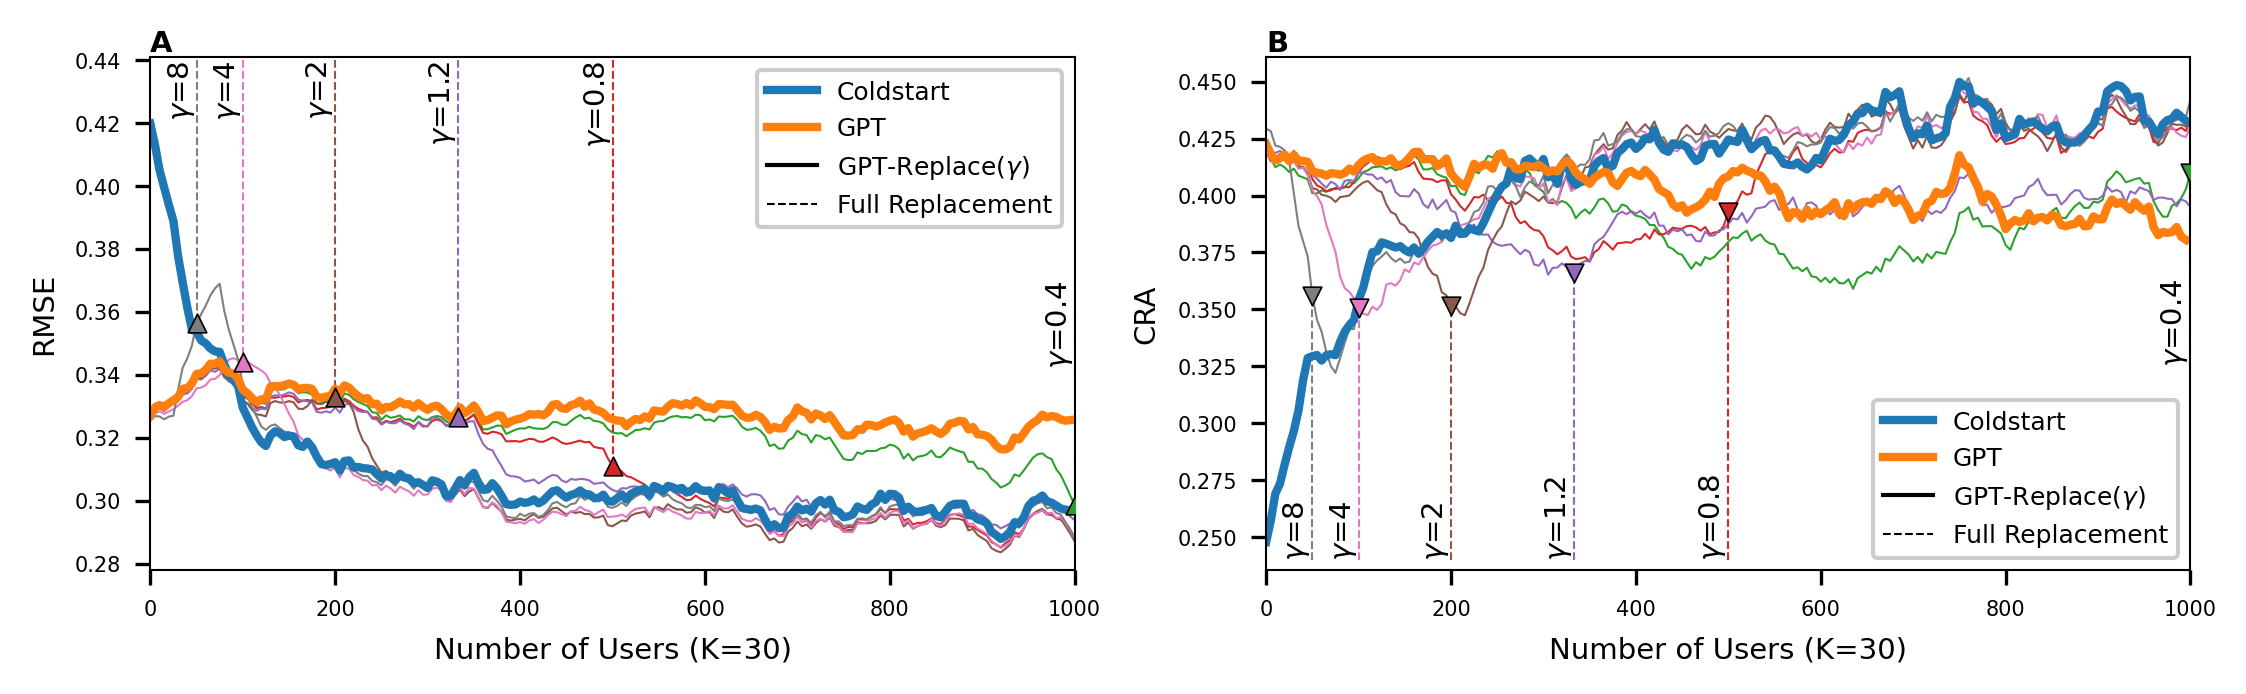

In [129]:
number_queries = 30
forget_steps = [2, 4, 6, 10, 20, 40]

identifiers = [
['Coldstart', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
['GPT', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False],
] 
for forget_step in forget_steps:
    for forget_max in [400]:
        identifiers.append([f'GPT-Replace-{forget_max}-{forget_step}', 'Uncertainty', f'{number_queries}Q', 'XPLORE', '5U', False])
        
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(vis.textwidth, 0.3*vis.textwidth))

fig, stats2 = plot_selection(identifiers, metric='CRA', legend=True, figratio=0.6, xmax=1000, lw=2, ax=ax2, ncols=2)
stats2lim = pd.DataFrame(stats2).iloc[0]
ymin, ymax = 0.95*stats2lim.apply(min).min(),1.02*stats2lim.apply(max).max()
ax2.set(ylim=(ymin, ymax),
        xlabel=f'Number of Users (K={number_queries})')


fig, stats1 = plot_selection(identifiers, metric='RMSE', xmax=1000,  legend=True, figratio=0.6,lw=2, ax=ax1, ncols=2)
stats1lim = pd.DataFrame(stats1).iloc[0]
ymin, ymax = 0.98*stats1lim.apply(min).min(),1.05*stats1lim.apply(max).max()
ax1.set(ylim=(ymin, ymax),
        xlabel=f'Number of Users (K={number_queries})')
fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax1.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax2.transAxes)

color = 'black'
blue_line = mlines.Line2D([], [], color='C0', linewidth=2, label='Coldstart')
orange_line = mlines.Line2D([], [], color='C1', linewidth=2, label='GPT')
black_line = mlines.Line2D([], [], color=color, linewidth=1, label=r'GPT-Replace($\gamma$)') 
dashed_line = mlines.Line2D([], [], color=color, linestyle='dashed', linewidth=0.5, label='Full Replacement') 
      

for i, ax in enumerate(fig.axes):
        lines = ax.get_lines()
        # lines[0].set_color('black')
        # lines[1].set_color('black')
        for j, line in enumerate(lines[2:]):
                # line.set_color('black') 
                line.set_linestyle(['-','-'][i % 2]) 
                line.set_linewidth(0.5)
                line.set_zorder(0)
     
        ylocs = [0.44, 0.24]
        yloc2 = [0.37, 0.325]
        orients = ['top', 'bottom']
        markers = [ '^','v']
        for j, forget_step in enumerate(forget_steps):
                yloc = ylocs[i] if forget_step != 2 else yloc2[i]
                x_target = 400/forget_step*5
                ax.text(x_target, yloc, rf'$\gamma$={forget_step/5:.1f}'.rstrip('0').rstrip('.'), rotation='vertical', va=orients[i], ha='right')
                ### Add a dot
                x_data, y_data = lines[j+2].get_data()
                y_target = np.interp(x_target, x_data, y_data)
                ax.scatter(x_target, y_target, color=f'C{j+2}', marker=markers[i], s=20, lw=.4,edgecolor='black', zorder=10)
                ax.plot([400/forget_step*5]*2, [yloc, y_target], color=f'C{j+2}',ls='--', lw=0.5, zorder=0)


        leg = ax.legend(handles=[blue_line, orange_line, black_line, dashed_line], loc='best', facecolor='w')
        leg.get_frame().set_alpha(1) 

fig.tight_layout()
vis.savefig(fig, title=f'Simulation_Replacement', destinations=save_figures)

### Overlap

In [4]:
def compute_overlap(dataset, benchmark, K):
      dfs = [results.loc[(results.NumberQueries==f'{K}Q')
                              & (results.Method=='Uncertainty')
                              & (results.InitialData==dataset)
                  ] for dataset in [benchmark, dataset]]
      assert set(dfs[1].Seed) == set(dfs[0].Seed), f"Seeds do not match for {dataset} and K={K} ({len(set(dfs[0].Seed))} vs. {len(set(dfs[1].Seed))})"

      overlaps = {}
      for seed in set(dfs[1].Seed):
            users0 = dfs[0].loc[dfs[0].Seed==seed, 'DataFrame'].iloc[0].Queries.iloc[:1000]
            users1 = dfs[1].loc[dfs[1].Seed==seed, 'DataFrame'].iloc[0].Queries.iloc[:1000]
            assert users0.index.equals(users1.index), f"Indices do not match for {dataset} and K={K} and seed={seed}"
            compare = pd.concat([users0, users1], axis=1)
            overlap = compare.apply(lambda row: met.overlap(pd.eval(row.iloc[0]), pd.eval(row.iloc[1])), axis=1) 
            overlaps[seed] = overlap
      return pd.DataFrame(overlaps).mean(axis=1)

In [5]:
forget_steps = [2, 4, 6, 10, 20, 40]
forget_max = 400
datasets = ['GPT'] + [f'GPT-Replace-{forget_max}-{forget_step}' for forget_step in forget_steps]
benchmark = 'Coldstart'

for K in [30]:
      overlaps = {}
      for dataset in datasets:
            overlaps[dataset] = compute_overlap(dataset, benchmark, K)
      overlaps = pd.DataFrame(overlaps)
      overlaps.to_csv(f'../results/analysis/Overlaps_{benchmark}_K{K}_Replace.csv')

<Axes: >

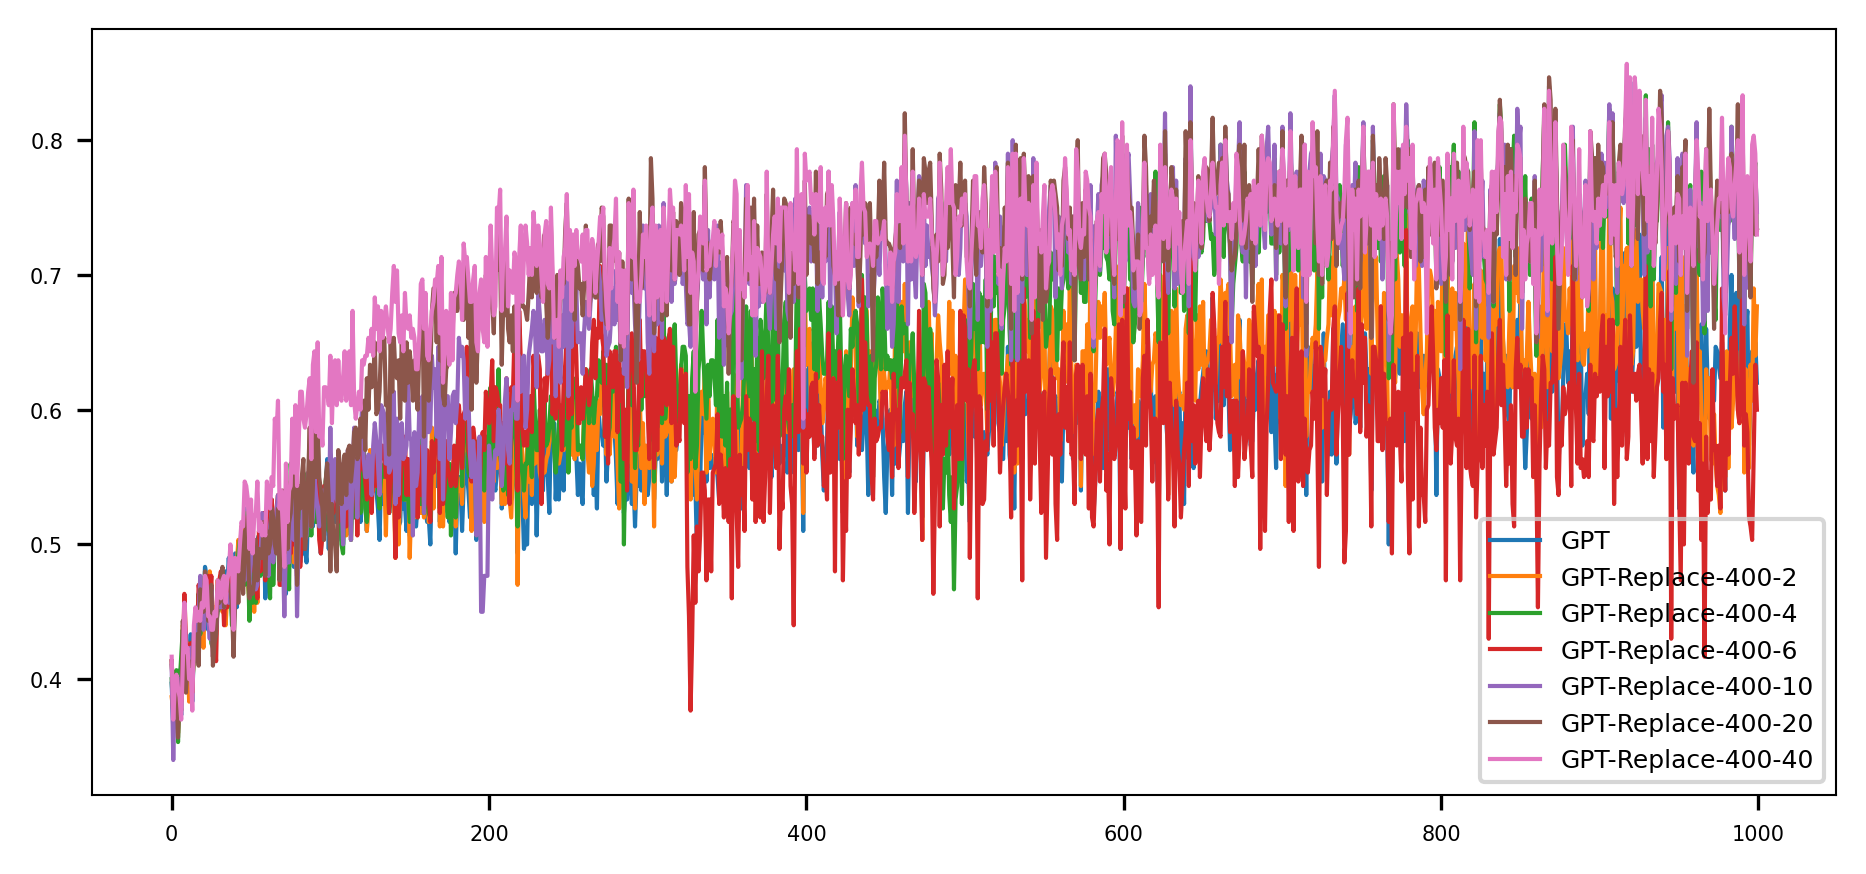

In [6]:
overlaps.plot()

In [26]:
datasets = ['GPT', 'GPTmeans', 'GPTvoters', 'Candidates']
benchmark = 'Coldstart'

for K in [30]:
      overlaps = {}
      for dataset in datasets:
            overlaps[dataset] = compute_overlap(dataset, 'Coldstart', K)
      overlaps = pd.DataFrame(overlaps)
      overlaps.to_csv(f'../results/analysis/Overlaps_{benchmark}_K{K}_GPT.csv')

<Axes: >

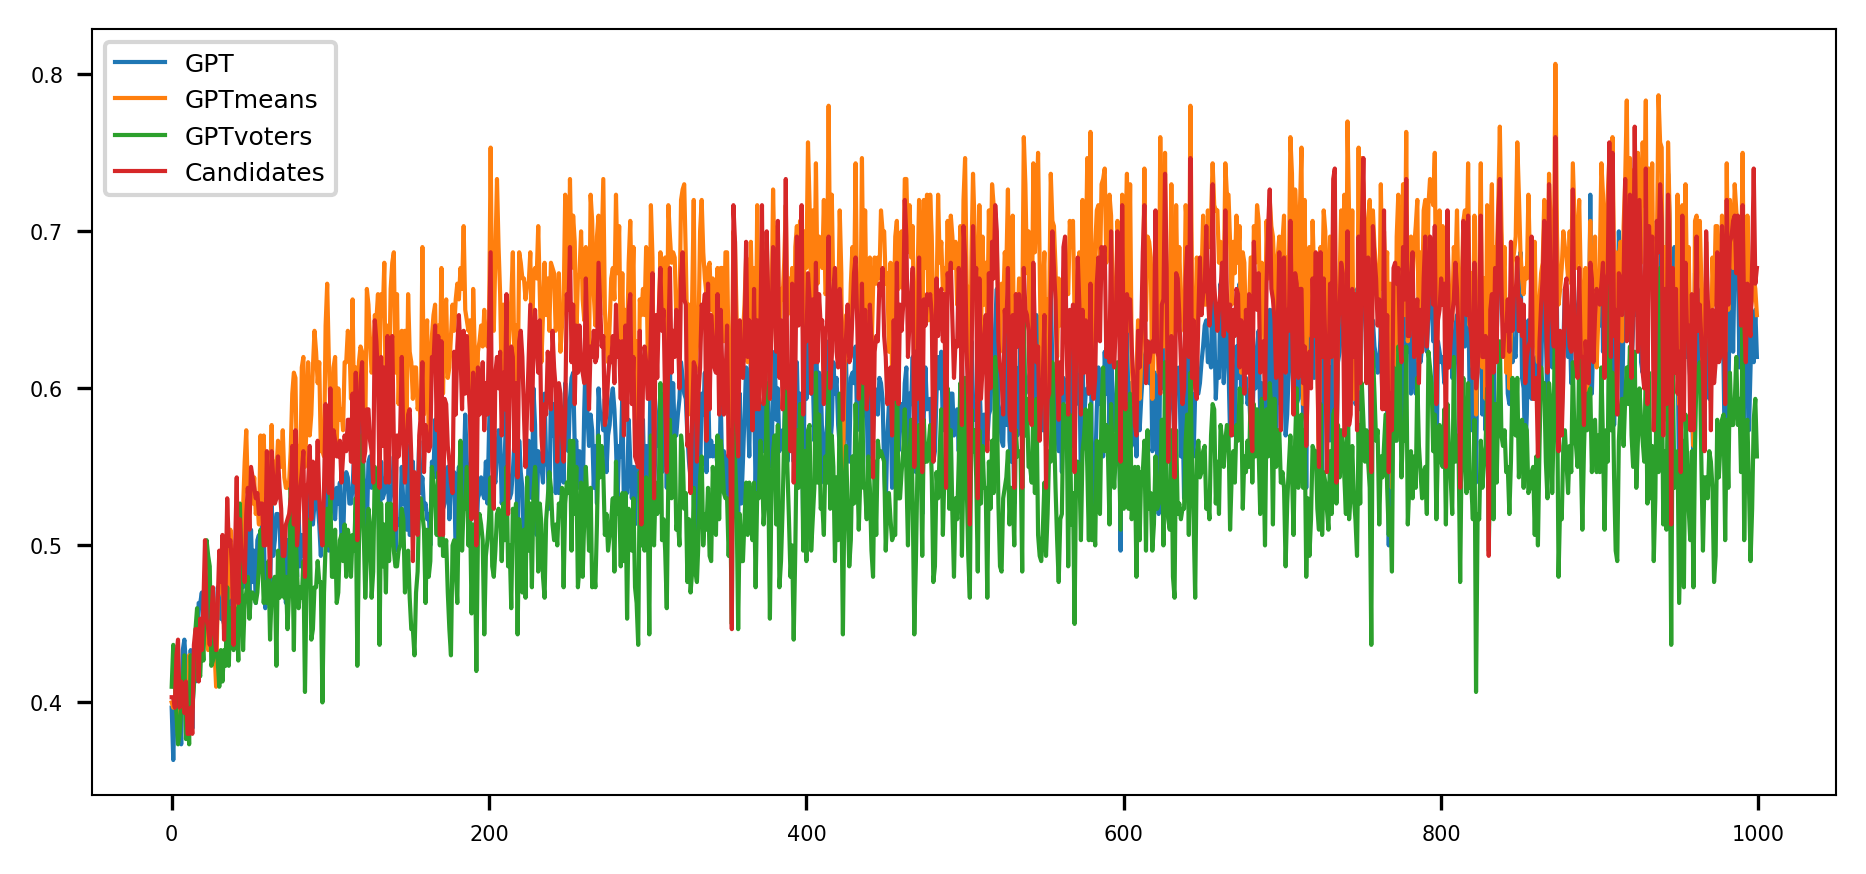

In [27]:
overlaps.plot()

#### Load and Plot

In [28]:
overlapsGPT = pd.read_csv('../results/analysis/Overlaps_Coldstart_K30_GPT.csv', index_col=0)
ratiosGPT = overlapsGPT.cumsum().div(overlapsGPT.index+1, axis=0)
ratiosGPT

,GPT,GPTmeans,GPTvoters,Candidates
0,0.396667,0.400000,0.410000,0.403333
1,0.380000,0.398333,0.423333,0.403333
2,0.387778,0.398889,0.421111,0.401111
3,0.390000,0.406667,0.414167,0.408333
4,0.388000,0.401333,0.406000,0.414667
...,...,...,...,...
995,0.580783,0.651459,0.529401,0.614809
996,0.580846,0.651464,0.529395,0.614875
997,0.580882,0.651483,0.529446,0.615000
998,0.580951,0.651495,0.529510,0.615052


In [19]:
overlapsReplace = pd.read_csv('../results/analysis/Overlaps_Coldstart_K30_Replace.csv', index_col=0)
K = 30
number_queries = 30
forget_steps = [2, 4, 6, 10, 20, 40]
full_replacement = [400*5/forget_step for forget_step in forget_steps]
ratiosReplace = overlapsReplace.cumsum().div(overlapsReplace.index+1, axis=0)
for i, start in enumerate(full_replacement):
    ratiosReplace.iloc[:int(start)-1, i+1] = np.nan
ratiosReplace

,GPT,GPT-Replace-400-2,GPT-Replace-400-4,GPT-Replace-400-6,GPT-Replace-400-10,GPT-Replace-400-20,GPT-Replace-400-40
0,0.396667,NaN,NaN,NaN,NaN,NaN,NaN
1,0.380000,NaN,NaN,NaN,NaN,NaN,NaN
2,0.387778,NaN,NaN,NaN,NaN,NaN,NaN
3,0.390000,NaN,NaN,NaN,NaN,NaN,NaN
4,0.388000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
995,0.580783,NaN,0.650020,0.577821,0.681479,0.697052,0.705371
996,0.580846,NaN,0.650144,0.577747,0.681575,0.697141,0.705463
997,0.580882,NaN,0.650264,0.577735,0.681667,0.697214,0.705561
998,0.580951,NaN,0.650397,0.577791,0.681762,0.697247,0.705646


In [21]:
full_ratios = (ratiosReplace*K + 75 - K)/75
full_ratios

,GPT,GPT-Replace-400-2,GPT-Replace-400-4,GPT-Replace-400-6,GPT-Replace-400-10,GPT-Replace-400-20,GPT-Replace-400-40
0,0.758667,NaN,NaN,NaN,NaN,NaN,NaN
1,0.752000,NaN,NaN,NaN,NaN,NaN,NaN
2,0.755111,NaN,NaN,NaN,NaN,NaN,NaN
3,0.756000,NaN,NaN,NaN,NaN,NaN,NaN
4,0.755200,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
995,0.832313,NaN,0.860008,0.831129,0.872592,0.878821,0.882149
996,0.832338,NaN,0.860058,0.831099,0.872630,0.878857,0.882185
997,0.832353,NaN,0.860106,0.831094,0.872667,0.878886,0.882224
998,0.832380,NaN,0.860159,0.831116,0.872705,0.878899,0.882258


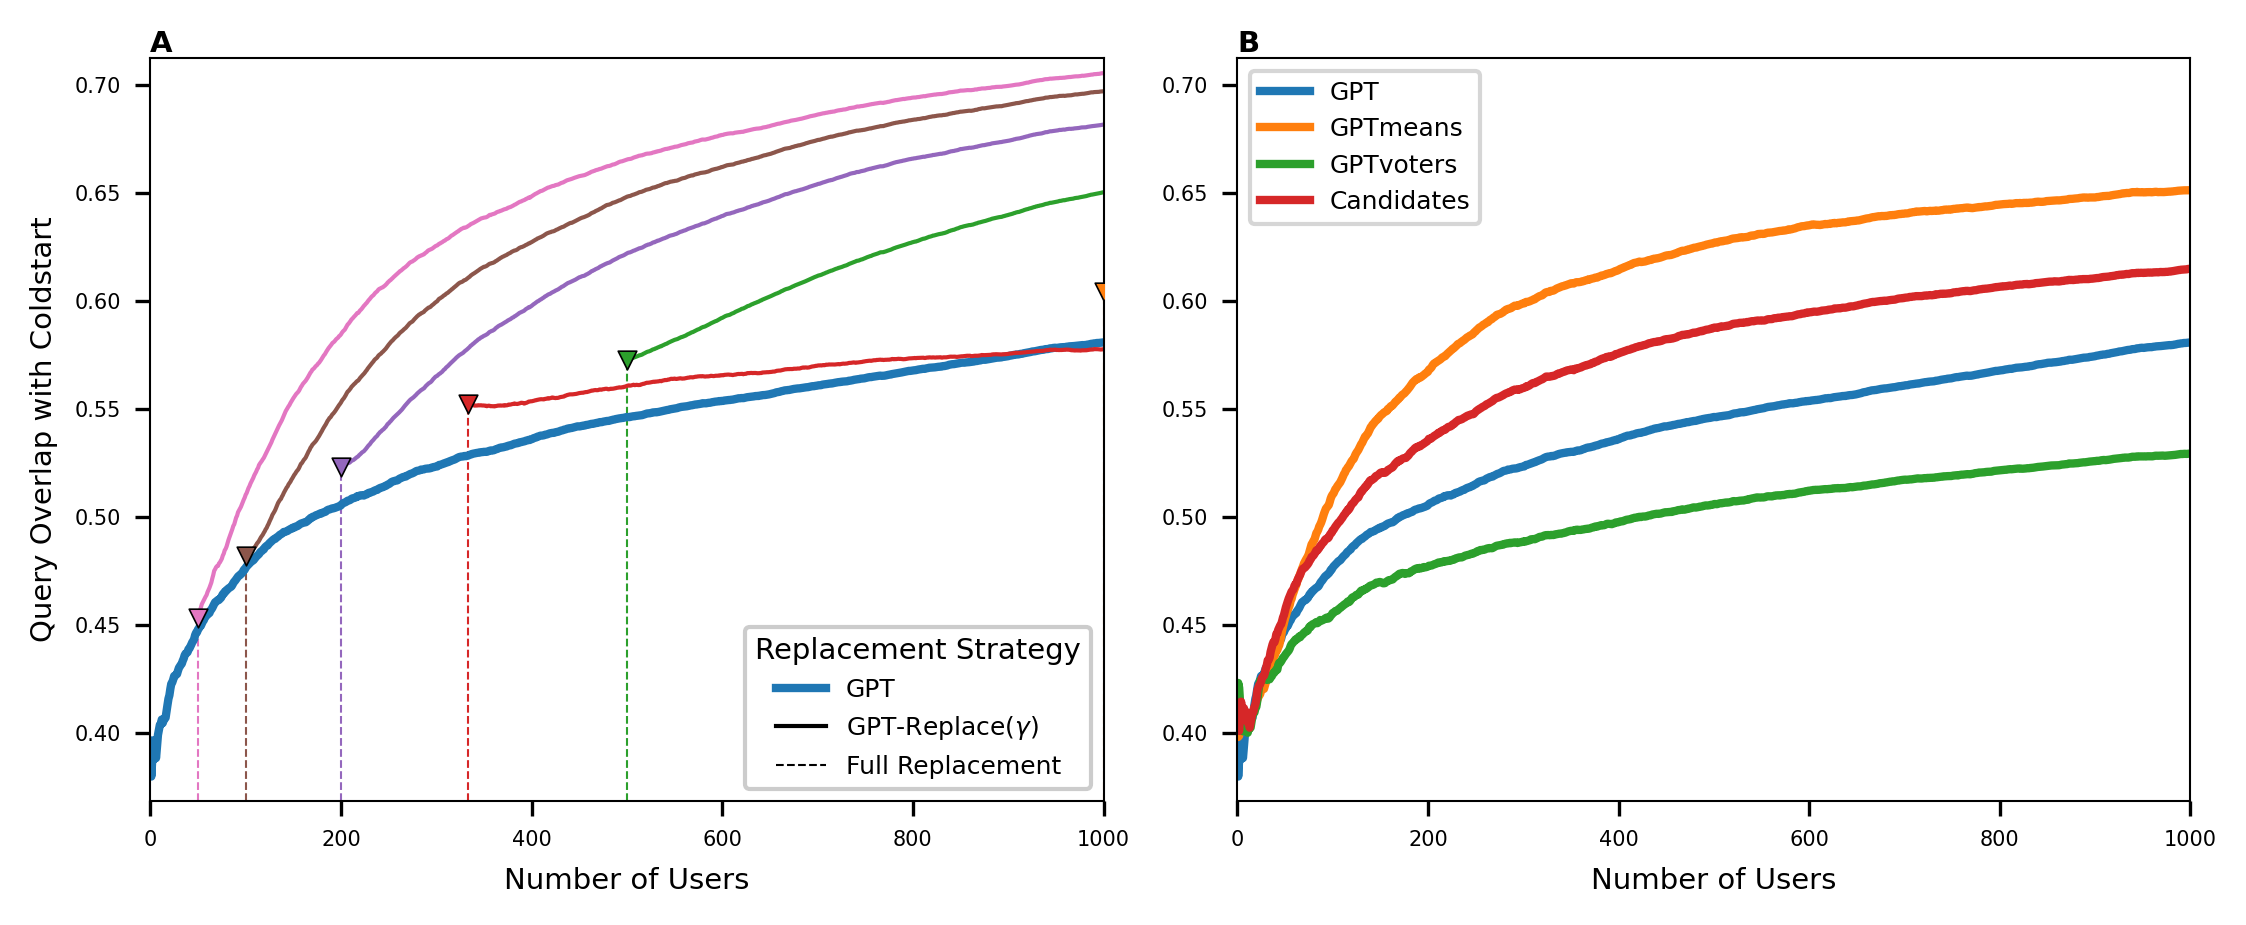

In [32]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(vis.textwidth, 0.4*vis.textwidth))

colors = [f'C{i+1}' for i in range(6)]
orange_line = mlines.Line2D([], [], color='C0', linewidth=2, label='GPT')
# black_line = vis.MultiLineHandle(colors, r'GPT-Replace($\gamma$)')
black_line = mlines.Line2D([], [], color='black', linewidth=1, label=r'GPT-Replace($\gamma$)')
dashed_line = mlines.Line2D([], [], color='black', linestyle='dashed', linewidth=0.5, label='Full Replacement')

ratiosReplace.plot(ax=ax, lw=2)
ylim = 0.97*data.min().min(), 1.01*ratiosReplace.max().max()
for i, start in enumerate(full_replacement):
    ax.scatter(start, ratiosReplace.iloc[int(start)-1, i+1], c=f'C{i+1}', marker='v', s=20, lw=.4, edgecolor='black', zorder=10)
    ax.plot([start]*2, [ylim[0], ratiosReplace.iloc[int(start)-1, i+1]], c=f'C{i+1}', ls='--', lw=.5, zorder=0)
    ax.get_lines()[i+1].set_linewidth(1)

    # yloc = ylocs[i] if forget_step != 2 else yloc2[i]
    # x_target = 400/forget_step*5
    # ax.text(x_target, yloc, rf'$\gamma$={forget_step/5:.1f}'.rstrip('0').rstrip('.'), rotation='vertical', va=orients[i], ha='right')
    # ### Add a dot
    # x_data, y_data = lines[j+2].get_data()
    # y_target = np.interp(x_target, x_data, y_data)
    # ax.scatter(x_target, y_target, c='black', marker=markers[i], s=20, lw=0, zorder=10)
    # ax.plot([400/forget_step*5]*2, [yloc, y_target], color=f'C{j+2}',ls='--', lw=0.5, zorder=0)

# Create the legend with a handler map that maps MultiLineHandle to MultiLineHandler.
leg = ax.legend(handles=[orange_line, black_line, dashed_line],
                # handler_map={vis.MultiLineHandle: vis.MultiLineHandler()},
                loc='best', facecolor='w', title='Replacement Strategy')
leg.get_frame().set_alpha(1)

for axis in fig.axes:
        axis.set(ylim=ylim,
                xlim=(0,1000),
                xlabel='Number of Users',
                ylabel='Query Overlap with Coldstart',
                )

ratiosGPT.plot(ax=bx, lw=2)

fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=ax.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=bx.transAxes)
bx.set_ylabel('')

fig.tight_layout()
vis.savefig(fig, title='Simulation_Replacement_Overlap_Ratios', destinations=save_figures)